In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

from extract import extract
import command_graph
import flags
from scripting import translate

Preliminaries: extract all the scripts from a vanilla ROM and label them.

In [2]:
scripts = extract()
print(f"Extracted {len(scripts)} scripts")

Extracted 383 scripts


Let's examine the translation of one of the simplest scripts, the Narshe Guard, encountered in the initial incursion sequence.

In general, the script translations will give you the actual byte value (typically in hexadecimal), and if arguments / parameters are also part of the command, they'll be offset by a new line and indented. The number of argments is specified in `[hexnum+nargs]`. You can ignore the `hexnum` part, that's internal and will eventually go away.

In [3]:
script = f"```\n{translate(scripts['Guard'])}\n```"
display(Markdown(script))

```
[0xf0] CHOOSE SPELL
	[0x100+3] Battle | Battle | Special
[0xff] END BLOCK
[0xff] END BLOCK

```

So basically, every turn, the Guard chooses its `Fight` equivalent (2/3 probability), or its `Special` (1/3 probability).

The AI script randomizer initially breaks this script into a [graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) which represents the adjacency relationships between the various primary command bytes (e.g. `0xF0` or `CHOOSE SPELL` above) and also tracks the subset of parameters which are used by the script, in this case `Battle` and `Special`. A graph is essentially a collection of nodes (representing the actual byte values used in the script) and edges (lines or arrows drawn between nodes) representing the adjacency.

We can generate this graph and visualize it.

In [4]:
# The reason behind this construction is twofold
# 1. The graph generator expects a dictionary of scripts to use, and we have all of them in a single dictionary
# 2. We only want the Guard script. We'll give it more later.
enemies = {"Guard"}
scripts_to_parse = {k: v for k, v in scripts.items() if k in enemies}

guard_graph = command_graph.CommandGraph()
guard_graph.from_scripts(scripts_to_parse)
guard_graph.visualize();

In general, I color command nodes blue and argument nodes red. Extraneous nodes, like `^`, are green.

The graph above is actually _directed_, which means that, when moving from node to node, you must follow the direction of the arrow. The green `^` is an internal marker (not used in the actual coding) which indicates the beginning of the script. Its only edge connects to the `CHOOSE SPELL` byte. The `[3]` next to it indicates that `CHOOSE SPELL` takes 3 arguments. `CHOOSE SPELL` has two outgoing edges (remember, it can't "go back" to the `^` node). One edge point towards the `Battle` node, which is, as you can see above, the first argument to `CHOOSE SPELL`.

`Battle` has two outgoing connections --- you can see that one of the points back to `CHOOSE SPELL`, we'll return to that. Following `Battle`'s other outgoing connection, we arrive at `Special` (the other possible selection in the script above) and that node points back to `CHOOSE SPELL` only.

Finally, `CHOOSE SPELL` has one last outgoing connection to `END BLOCK` (`0xFF` in hex). That command is effectively a no-op instruction which ends either the first "main" block of the script, or the second "counter" block of the script. That means that the simplest parseable script is:

In [5]:
script = b"\xFF\xFF"
script = f"```\n{translate(script)}\n```"
display(Markdown(script))

```
[0xff] END BLOCK
[0xff] END BLOCK

```

The way that the generator actually goes about generating a new script from this is similar to the description of how to read the graph. It starts at the green `^` (Begin Script) marker, and chooses a random command byte to "move" to and try to insert into the (currently empty) script. In this case, it'd have no choice but to move to `CHOOSE SPELL`. Then it has to fill in arguments. In practice, the `CommandGraph` object keeps the command bytes and argument bytes (per command) separate, and after choosing a command byte, it will expand the three arguments by following a random graph connection (in this case to `Battle`) and continuing to follow random connections in the argument subgraph.

You may think at this point that we're in trouble because we need three arguments, but there are only two which can be "followed" to. But this is where the connection back to the command byte takes over. The algorithm can choose to return to the command byte at any point in the generation sequence (all the argument nodes point back to the command byte), and if there are no other choices, it will return by default. The algorithm then repeats the selection process until it has enough arguments to fill all three slots.

Now the algorithm has to choose its next command byte. However, this particular graph doesn't have a self connection between the `CHOOSE SPELL` node and itself that would allow for repetition. (It's feasible, just not in the algorithm yet.) So, its only choice is to head to the `END BLOCK` command, which takes no arguments and would end the main block.

At this point, the algorithm has nowhere to go, and the script isn't complete yet. It hasn't yet filled out a counter block. However, the `END BLOCK` has a self connection (which isn't visualized properly above) and so the next step will be towards itself, and that will end the (empty) counter block and the script itself.

There's an example of the generation process from the Guard below. After a few iterations, that's as complex as it would get. More often than not, for something as simple as the Guard script, you'll get a script with two empty blocks. However, do notice that the `CHOOSE SPELL` that was inserted does not have the "vanilla" selections; instead it has three `Battle`s. So, *something* is being randomized, even if it's not particularly interesting.

In [6]:
script = guard_graph.generate_from_graph()
script = f"```\n{translate(script)}\n```"
display(Markdown(script))

```
[0xf0] CHOOSE SPELL
	[0x100+3] Battle | Battle | Battle
[0xff] END BLOCK
[0xff] END BLOCK

```

Clearly, we aren't going to get great results with such a small reservoir of commands / arguments to work with, so let's move to something with a bit more complexity, the Lobo.

In [7]:
script = f"```\n{translate(scripts['Lobo'])}\n```"
display(Markdown(script))

```
[0xfc] CMD PRED
	IF LEVEL >= 0x44 0x7
[0xf0] CHOOSE SPELL
	[0x100+3] Battle | Special | Nothing
[0xf0] CHOOSE SPELL
	[0x100+3] Special | Nothing | Nothing
[0xfe] END FC BLOCK
[] Battle
[0xff] END BLOCK
[0xff] END BLOCK

```

There's a few more command bytes we haven't seen yet. The first is `0xFC` or `CMD PRED`, and its paired closer `0xFE` or `END FC BLOCK`. We'll come back to that, but first, it's important to note that there's a "byteless" command here: `Battle`. Notice there's no hexadecimal number in brackets. This is an indicator to the script interpreter to *unconditionally* do this action. In my internal script parser, this is given a "phantom" indicator of `_`, but there's no actual byte to process there.

Returning to `0xFC`; this is the way the game implements conditional actions. It takes three bytes, the first corresponds to the type of condition, the second target of the first byte, and the third the numerical value to compare against. Not all `0xFC` commands parse like this, however. The way to read the one in the Lobo script, first in pseudo-python, then in pseudo-English:

```python
if random.choice(party).level >= 7:
    choose_spell()
    choose_spell()
battle()
```

In "English":

```
if the level of a party member chosen randomly is greater than or equal to 7
    then choose a spell from the first list
    and then choose another spell from the second list
unconditionally use Battle
```

...and just to clarify the targeting byte:

In [8]:
flags.TARGET_LIST[0x44]

'Random character'

So, in the case of Lobo, it doesn't do anything interesting when everyone's level is below 7. This is unlikely to occur in the initial Narshe sequence, you might only ever see this if you overlevel in the Narshe Mines and fight the Guard in Locke's rescue sequence or pick a fight with the MiaB in the Beginner's Hall.

It's important to know that *everything* that is listed after the `CMD PRED` is part of that conditional block. If the check fails, then nothing is executed until the script reaches the end of the predicate block `END FC BLOCK` or the end of the block entirely (`END BLOCK`). In the Lobo's case, that means you probably only ever saw it `Battle`, due to the relatively high level check.

There are several other conditionals that are possible:

In [9]:
flags.FC_MODIFIERS

{1: 'IF CMD USED',
 2: 'IF SPELL USED',
 3: 'IF ITEM USED',
 4: 'IF ELEM ATK',
 5: 'IF DAMAGED',
 6: 'IF HP <',
 7: 'IF MP <',
 8: 'IF HAS STATUS',
 9: 'IF NOT HAS STATUS',
 13: 'VAR >',
 10: 'NOT EXE',
 11: 'ETIMER >',
 12: 'VAR <',
 15: 'IF LEVEL >=',
 16: 'IF SINGLE ETYPE',
 17: 'IS ALIVE',
 18: 'IS DEAD',
 19: 'IF ANY ALIVE',
 20: 'IF VAR BIT',
 21: 'IF NOT VAR BIT',
 22: 'BAT TIMER >',
 23: 'SET TARGET',
 24: 'IF GAU JOINED',
 25: 'IF FORM #',
 26: 'IF WEAK TO',
 27: 'IS FORM # =',
 28: 'ALWAYS'}

Let's look at the Lobo graph.

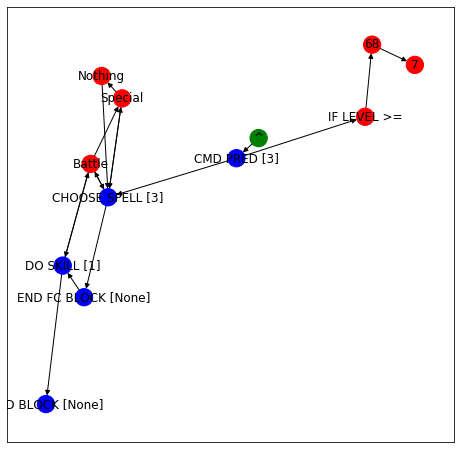

In [10]:
enemies = {"Lobo"}
scripts_to_parse = {k: v for k, v in scripts.items() if k in enemies}

lobo_graph = command_graph.CommandGraph()
lobo_graph.from_scripts(scripts_to_parse)
lobo_graph.visualize();

You can see that the graph node quantity has almost doubled. The script is more or less guaranteed to start with the conditional. However, in this case, `CHOOSE SPELL` now has a self loop, thanks to the internal part of the conditional, so it may appear more or less frequently than it does in the Lobo script. Let's try an example:

In [11]:
script = lobo_graph.generate_from_graph()
script = f"```\n{translate(script)}\n```"
display(Markdown(script))

```
[0xfc] CMD PRED
	IF LEVEL >= 0x44 0x7
[0xf0] CHOOSE SPELL
	[0x100+3] Special | Nothing | Nothing
[0xf0] CHOOSE SPELL
	[0x100+3] Special | Special | Nothing
[0xf0] CHOOSE SPELL
	[0x100+3] Special | Nothing | Nothing
[0xff] END BLOCK
[0xff] END BLOCK

```

Looks quite similar to the original script, but you can see there's only one `CHOOSE SPELL` in the conditional, and it has a different set of arguments to choose from. The predicate conditions are identical.

You may notice, if you experiment on your own that the scripts can end "earlier" than you expect, e.g., you get an end block before the connection would nominally allow. This is a design decision. Because graphs can easily get very complicated, and have lots of connections between commands, arbitrarly long scripts are possible. Also, conditional blocks can grow in similar ways. So, the algorithm will, with some random but increasing probability, begin to close off blocks or conditional blocks as their size grows. This guarantees that infinitely long scripts are impossible, and that longer scripts are less probable than shorter ones.

Okay, so if you've followed to this point, you're probably unimpressed. All that appears to have been done here is slight tweaks to otherwise vanilla scripts. There are a couple of ways to greatly increase the possible script complexity:

    1. Manually change / add command node connections. 
    2. Generate a random script from a more complex enemy
    3. Merge graphs
    
The first will become more and more possible as custom components are created and added to the library. At the moment, that would be a lot of work, so you're welcome to try on your own, but there's no pre-programmed way to do it. The second is, of course, possible, but you'd be still limited to the connections present in that enemy's script. Most importantly, you'd be limited to the attacks / conditions that are present in that script.

So the most readily apparent choice is 3, and it's easy to accomplish with the graphs. One can "merge" the script graphs, which is to say, the two graphs are composed together. All the nodes from either script are copied to a new graph, and all the connections between both are translated to the new graph as well. It's the composition of those connections which allows for greater complexity. We'll go all out and combine all three enemies seen in the beginning of the Narshe sequence: Guard, Lobo, and Vomammoth. We haven't yet seen the script for Vomammoth, so let's do that first:

In [12]:
script = f"```\n{translate(scripts['Vomammoth'])}\n```"
display(Markdown(script))

```
[0xfc] CMD PRED
	IF LEVEL >= 0x44 0x5
[0xf1] TARGETTING
	[0x101+1] All characters
[] Blizzard
[0xfd] WAIT
[0xf0] CHOOSE SPELL
	[0x100+3] Battle | Nothing | Special
[0xf0] CHOOSE SPELL
	[0x100+3] Battle | Battle | Special
[0xfe] END FC BLOCK
[] Battle
[0xff] END BLOCK
[0xff] END BLOCK

```

As is apparent, Vomammoth is the most complex script we've seen yet. It checks if the level is above *5*, and changes targeting (through `0xF1` or `TARGETTING` of its Blizzard attack to hit everyone. This is a kind of "difficulty modifier". There's also a `0xFD` or `WAIT` instruction directly after, which stops execution of the script for the turn, to be picked up at this point next time. If none of your characters are level 5 or above, you will only ever see it attack normally. However, most of you have seen Blizzard, because hitting level 5 (with speedrun exp strats for instance) is possible, and we see the Vomammoth again in the Narshe escape sequence.

Okay, we're ready. Let's merge this into a horrific mash-up.

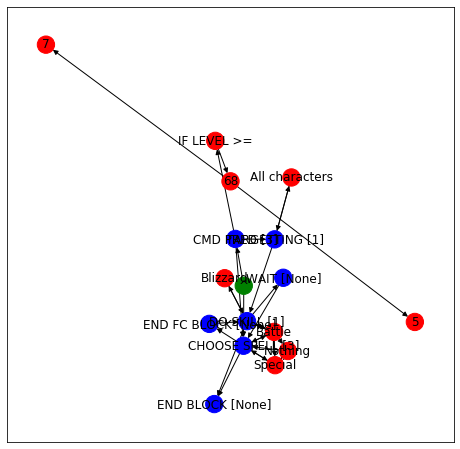

In [13]:
# NOW we have more enemies to add together
enemies = {"Guard", "Lobo", "Vomammoth"}
scripts_to_parse = {k: v for k, v in scripts.items() if k in enemies}

narshe_graph = command_graph.CommandGraph()
narshe_graph.from_scripts(scripts_to_parse)
narshe_graph.visualize();

So, we see the "pieces" of all three scripts represented here. The allowable conditions and attacks are much richer now. Let's try generating a script.

In [14]:
script = narshe_graph.generate_from_graph()
script = f"```\n{translate(script)}\n```"
display(Markdown(script))

```
[0xf0] CHOOSE SPELL
	[0x100+3] Battle | Nothing | Nothing
[0xf0] CHOOSE SPELL
	[0x100+3] Special | Special | Battle
[0xff] END BLOCK
[0xff] END BLOCK

```

After a few tries, I got something relatively interesting. Here's the pseudocode, again in python, then English:

```python
if actors[16] >= 68:
    attack(everyone)
    pause()
attack()
```

```
If the character in the 16th slot has level greater than or equal to 68
    attack everyone
    and pause
attack
```

So, you've now seen that not only can we create new scripts from smaller pieces, but that we can, in fact, create *invalid* scripts! Whoops. There are two problems with this script:
    1. Battle __cannot__ target everyone, so the default targeting is restored and `TARGETTING` is superfluous.
    2. There is no 16th actor (14 is the maximum)

There's also no counter block, because none of the three we merged have counters, so the algorithm never "learned" how to do that.
    
So, what the script would do is undetermined since we don't know how the engine would interpret that out of bounds value. Beyond that, it's obvious that early game you're unlikely to be level 68 in any case. However, while that set of commands is permanently hidden, and may crash the game, if it doesn't, you'd only ever see it attack. Still, this is a good sign, since the algorithm can produce a syntactically correct, entirely new, script from learned components. We just need to be more careful with the way the arguments are generated. If you examine the graph above, you may see the issue. Our little "hack" to allow `CHOOSE SPELL` lists to be a bit more varied backfired. The `CMD PRED` nodes were visited in this order:

```
CMD PRED -> IF LEVEL >= -> CMD PRED -> IF LEVEL >= -> Target Random
```

Combined with the knowledge that `IF LEVEL >=` is represented by a byte with the value 15 (`0xF`), and Target Random is the `68` (`0x44`) represented in the next connection, we can see how we arrived there. So, that connection that we allowed between each argument and the command byte produce a cycle which, while allowing for more variance, produced a set of syntactically valid, but meaningless conditional. The targeting mishap is harder to navigate around, because the targeting is often story-dependent, e.g., targeting Banon. It's also more harmless, because the game has default targeting for all skills and spells, so at the worst, you get an attack which doesn't *quite* do what you intended.

Long story short, it's a work in progress, and some manual verification and tweaking is needed at the moment.

Well, let's just go ahead and break the whole thing, shall we? What if we "merge" the two components of the Whelk boss battle (its shell and head are two independent enemies). Here are the scripts we'll merge:

In [15]:
script = f"### Whelk Shell\n```\n{translate(scripts['Whelk'])}\n```"
script += f"\n### Whelk Head\n```\n{translate(scripts['Head'])}\n```"
display(Markdown(script))

### Whelk Shell
```
[0xfc] CMD PRED
	IF NOT VAR BIT 0x3 0x0
[0xf9] VAR MANIP
	[0x109+3] 0x0 0x3 0x0
[0xf7] SPECIAL EVENT
	[0x107+1] 0x5
[0xfe] END FC BLOCK
[0xfc] CMD PRED
	ETIMER > 0xa 0x0
[0xfc] CMD PRED
	IS DEAD 0x2 0x0
[0xf3] DISPLAY MESSAGE
	[0x103+2] 0x5 0x0
[0xf5] ALTER FORMATION
	[0x105+3] 0x9 0x2 0x2
[0xfb] MISC.
	[0x10b+2] TARG BAT TIME RESET 0x0
[0xfe] END FC BLOCK
[0xfc] CMD PRED
	ETIMER > 0xa 0x0
[0xfc] CMD PRED
	IS ALIVE 0x2 0x0
[0xf3] DISPLAY MESSAGE
	[0x103+2] 0x5 0x0
[0xf5] ALTER FORMATION
	[0x105+3] 0x8 0x1 0x2
[0xfb] MISC.
	[0x10b+2] TARG BAT TIME RESET 0x0
[0xff] END BLOCK
[0xfc] CMD PRED
	IS DEAD 0x0 0x0
[0xf5] ALTER FORMATION
	[0x105+3] 0xc 0x1 0xff
[0xfe] END FC BLOCK
[0xfc] CMD PRED
	IF DAMAGED 0x0 0x0
[0xf1] TARGETTING
	[0x101+1] Use normal targetting
[] Mega Volt
[0xfe] END FC BLOCK
[0xff] END BLOCK

```
### Whelk Head
```
[0xf0] CHOOSE SPELL
	[0x100+3] Battle | Battle | Special
[0xff] END BLOCK
[0xfc] CMD PRED
	IS DEAD 0x0 0x0
[0xf5] ALTER FORMATION
	[0x105+3] 0xc 0x1 0xff
[0xff] END BLOCK

```

That's got a little bit of everything, including several less-used command bytes. In general, randomization over things that affect formation is unsafe, since there are no checks that the formation alteration / swap is allowed by the battle engine. So, again, we can generate syntactically correct scripts, but they'll likely break the battle engine and soft (or hard) lock the game. Notice, also, the manipulation of variables. Currently, variable use is allowed, but not explicitly handled very well by the algorithm. Namely, it doesn't check that the variables being checked or manipulated correspond to something meaningful to that particular formation.

There's also a special event called in (`0x5`): The semi-tutorial by Wedge and Vicks at the opening of the battle (enclosed in a variable check which won't allow it to occur more than once.) Beyond that, most of the commands are things controlling/resetting the battle timer, and altering the formation to alternately display and hide the head. Finally, both have counter blocks. First, there's the well known shell counter of `Mega Volt`. The Whelk head's counter script is less obvious. There's two predicates it checks: whether itself is dead and a variable bit is set. If so, it twiddles some bits in the variable and then executes the `0xF5` instruction (`ALTER FORMATION`). This is the most common pattern for `ALTER FORMATION` and in particular is the "die like a boss" event with the famous crackboom and distintegration. You'll see the shell has this as well.

(Side note: I have *no* idea where the `El Nino` comes from. I might be parsing that one incorrectly.)

So combining these scripts might be interesting, but it might also produce unpredictable results, since there's going to be a good bit of variable manipulation and formation changes which may not make sense. Let's try anyway.

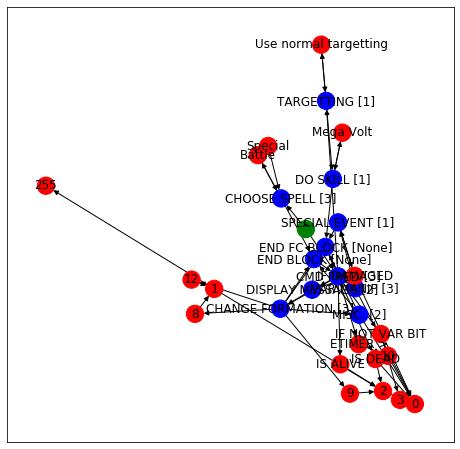

In [16]:
enemies = {"Whelk", "Head"}
scripts_to_parse = {k: v for k, v in scripts.items() if k in enemies}

whelk_graph = command_graph.CommandGraph()
whelk_graph.from_scripts(scripts_to_parse)
whelk_graph.visualize();

...what a mess...

In [17]:
script = []
script = whelk_graph.generate_from_graph(main_block_len=5)
script = f"```\n{translate(script)}\n```"
display(Markdown(script))

```
[0xf0] CHOOSE SPELL
	[0x100+3] Battle | Battle | Battle
[0xff] END BLOCK
[0xfc] CMD PRED
	IF DAMAGED 0x0 0x0
[0xf9] VAR MANIP
	[0x109+3] 0x0 0x3 0x0
[0xf7] SPECIAL EVENT
	[0x107+1] 0x5
[0xfe] END FC BLOCK
[0xfc] CMD PRED
	IF DAMAGED 0x0 0x0
[0xf5] ALTER FORMATION
	[0x105+3] 0x8 0x1 0xff
[0xfe] END FC BLOCK
[0xff] END BLOCK

```

As you can see, I had to convince it to keep trying until the script was of sufficient length to be "boss worthy". Script length will become more controllable as the library develops.

But it worked. ...kinda. There's definitely recognizeable pieces of either script present here. Lots of predicates and variable manipulation --- we could dive deeper and see if it makes any sense, but it probably doesn't. Here are a few highlights though:

The main body has no actual attacks. It just checks if it's damaged and attempts to do some math with a variable (which may or may not be valid). The counter block is much more extensive. There's several predicates checking/manipulating/twiddling various variables (which may or may not actually be valid), and the "Gruuu" message would be displayed if the predicate actually fired. The latter part of the block is 4-way predicate which is unlikely to ever be able to fire --- it suffers from the same issue that we saw in earlier merges with `CMD PRED`. But, here's a gem buried in the counter block:

```
[0xfc] CMD PRED
    IS DEAD 0x0 0x0
[0xf0] CHOOSE SPELL
    [0x100+3] Battle | El Nino | Special
[0xfd] WAIT
[0xfe] END FC BLOCK
```

That, folks, is a death counter of sorts, or final attack --- it's checking if the enemy party is wiped out. It pieced together the "die like a boss" command with a `CHOOSE SPELL` command. This is a *hint* of emergent mechanics.

__PROGRESS!__

The next steps will focus on cleaning up and validating variable manipulation, as well as weighting the command bytes so as to emphasize actual attack dynamics, rather than internal manipulations. In a related note, you can actually turn those off (`0xF8` and `0xF9` are variable related commands and `0xF2` and `0xF5` are the formation related commands):

In [18]:
script = []
script = whelk_graph.generate_from_graph(disallow_commands={0xF8, 0xF9, 0xF5, 0xF2})
script = f"```\n{translate(script)}\n```"
display(Markdown(script))

```
[0xfc] CMD PRED
	IS DEAD 0x0 0x0
[0xf3] DISPLAY MESSAGE
	[0x103+2] 0x5 0x0
[0xf0] CHOOSE SPELL
	[0x100+3] Battle | Special | Battle
[0xff] END BLOCK
[0xfc] CMD PRED
	IF NOT VAR BIT 0x3 0x0
[0xfc] CMD PRED
	ETIMER > 0xa 0x0
[0xfc] CMD PRED
	IF NOT VAR BIT 0x3 0x0
[0xf1] TARGETTING
	[0x101+1] Use normal targetting

```

I mean... it's not dazzling, but there's a twist or two in there. The reason this doesn't work quite as well is because removing those command nodes also removes their connections and reduces the complexity of the allowed script. Add in the fact that the script is *required* to start with a `CMD PRED` (both Whelk components do) and you get something that's a little less than inspiring.

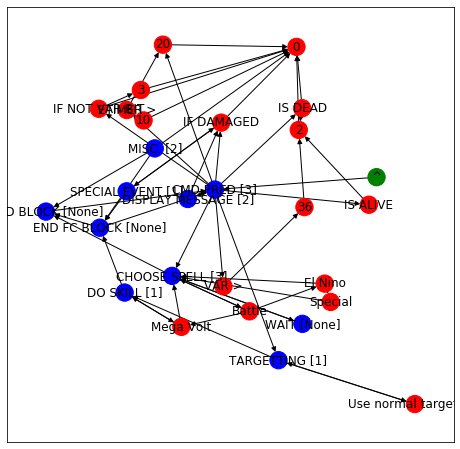

In [19]:
enemies = {"Whelk", "Whelk?Head"}
scripts_to_parse = {k: v for k, v in scripts.items() if k in enemies}

whelk_graph = command_graph.CommandGraph()
whelk_graph.from_scripts(scripts_to_parse)

disallowed_commands = {0xF8, 0xF9, 0xF5, 0xF2}
whelk_graph.cmd_graph.remove_nodes_from(disallowed_commands)
for cmd in disallowed_commands:
    del whelk_graph.cmd_arg_graphs[cmd]

whelk_graph.visualize();